In [1]:
# My code
import fast_gillespie as fg
import fast_gillespie_viz as fgv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx

In [2]:
#Define cooperative binding trimer

# Rates in terms of interpretable quantities
mean_num_A_monomers = 100.0
mean_num_C_monomers = 100.0  
mean_num_dimers= 50.0
mean_num_trimers = 200.0
rate1p = mean_num_A_monomers
rate1m = 1.0
rate2p = mean_num_C_monomers
rate2m = 1.0
rate3p = 3*mean_num_dimers/(2*mean_num_A_monomers*mean_num_C_monomers)
rate3m = 3*1.0
rate4p = 0.5*mean_num_trimers/((mean_num_C_monomers)*mean_num_dimers)
rate4m = 0.5*0.5

# Print out rate-determining quantities
print('mean_num_A_monomers = ', mean_num_A_monomers)
print('mean_num_B_monomers = ', mean_num_C_monomers)
print('mean_num_dimers = ', mean_num_dimers)
print('mean_num_trimers = ', mean_num_trimers)

# Create fields
A = fg.Field(name='A', index_dim=1)
C = fg.Field(name='C', index_dim=1)
a = fg.Field(name='a', index_dim=1)
b = fg.Field(name='b', index_dim=1)
c = fg.Field(name='c', index_dim=1)
J = fg.Field(name='J', index_dim=2)

# Create rules 
R_1p = fg.MonomerCreationRule(name='R_1p', rate=rate1p, particle=A, sites=[a,b])
R_1m = fg.MonomerAnnihilationRule(name='R_1m', rate=rate1m, particle=A, sites=[a,b])
R_2p = fg.MonomerCreationRule(name='R_2p', rate=rate2p, particle=C, sites=[c])
R_2m = fg.MonomerAnnihilationRule(name='R_2m', rate=rate2m, particle=C, sites=[c])

kwargs = dict(A=A, B=C, b=c, J=J)
R_3p1 = fg.HeterotypicInteractionCreationRule(name='R_3p1', rate=rate3p, 
                                              a=a, A_sites_vacant=(b,), **kwargs)
R_3m1 = fg.HeterotypicInteractionAnnihilationRule(name='R_3m1', rate=rate3m,
                                                  a=a, A_sites_vacant=(b,), **kwargs)      
R_3p2 = fg.HeterotypicInteractionCreationRule(name='R_3p2', rate=rate3p, 
                                              a=b, A_sites_vacant=(a,), **kwargs)
R_3m2 = fg.HeterotypicInteractionAnnihilationRule(name='R_3m2', rate=rate3m, 
                                                  a=b, A_sites_vacant=(a,), **kwargs) 

R_4p1 = fg.HeterotypicInteractionCreationRule(name='R_4p1', rate=rate4p, 
                                              a=a, A_sites_occupied=(b,), **kwargs)
R_4m1 = fg.HeterotypicInteractionAnnihilationRule(name='R_4m1', rate=rate4m, 
                                                  a=a, A_sites_occupied=(b,), **kwargs)    
R_4p2 = fg.HeterotypicInteractionCreationRule(name='R_4p2', rate=rate4p, 
                                              a=b, A_sites_occupied=(a,), **kwargs)
R_4m2 = fg.HeterotypicInteractionAnnihilationRule(name='R_4m2', rate=rate4m, 
                                                  a=b, A_sites_occupied=(a,), **kwargs)   

# Define fock space and rules
space = fg.FockSpace(fields=[A, C, a, b, c, J])
rules = fg.RuleSet(rules=[R_1p, R_1m, R_2p, R_2m, R_3p1, R_3m1, R_3p2, R_3m2, R_4p1, R_4m1, R_4p2, R_4m2])

mean_num_A_monomers =  100.0
mean_num_B_monomers =  100.0
mean_num_dimers =  50.0
mean_num_trimers =  200.0


Progress:   0%|          | 0/30000 [00:00<?, ?it/s]

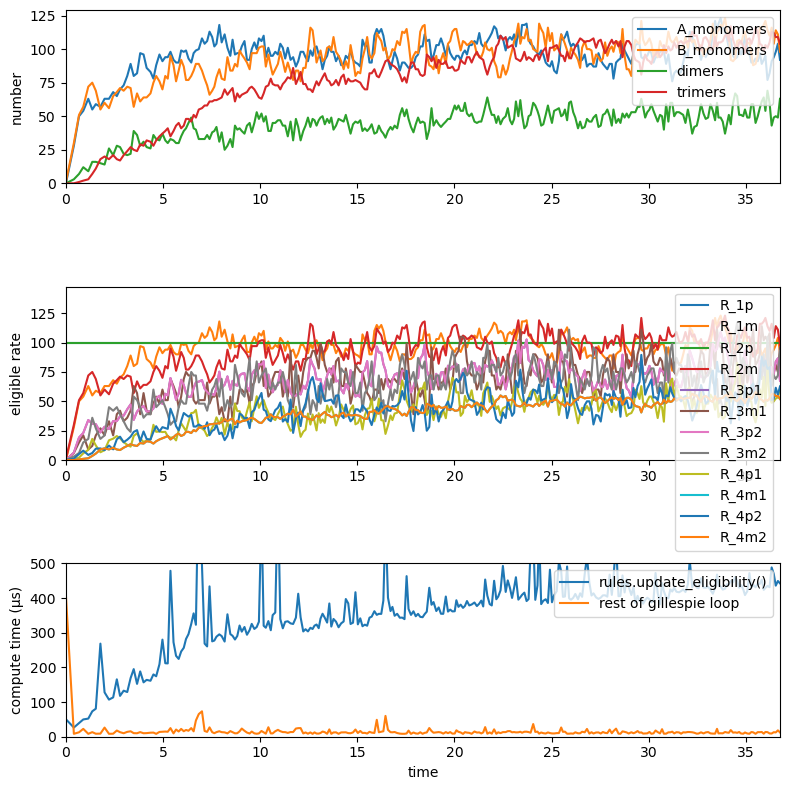

In [3]:
def summary_stats_func():
    stats_dict = dict(
        A_monomers=len(A.indices - (a.indices | b.indices)),
        B_monomers=len(C.indices - c.indices),
        dimers=len(A.indices & ((a.indices - b.indices) |  (b.indices - a.indices))),
        trimers=len(A.indices & (a.indices & b.indices)),
    )
    return stats_dict

# Define, initialize, and run simulation
sim = fg.Simulation(space=space, rules=rules, custom_stats_func=summary_stats_func)
sim.initialize_state()
sim.run(num_steps=30_000, record_every=100)

# Show simulation stats
fgv.show_sim_stats(sim, x_is_time=True)

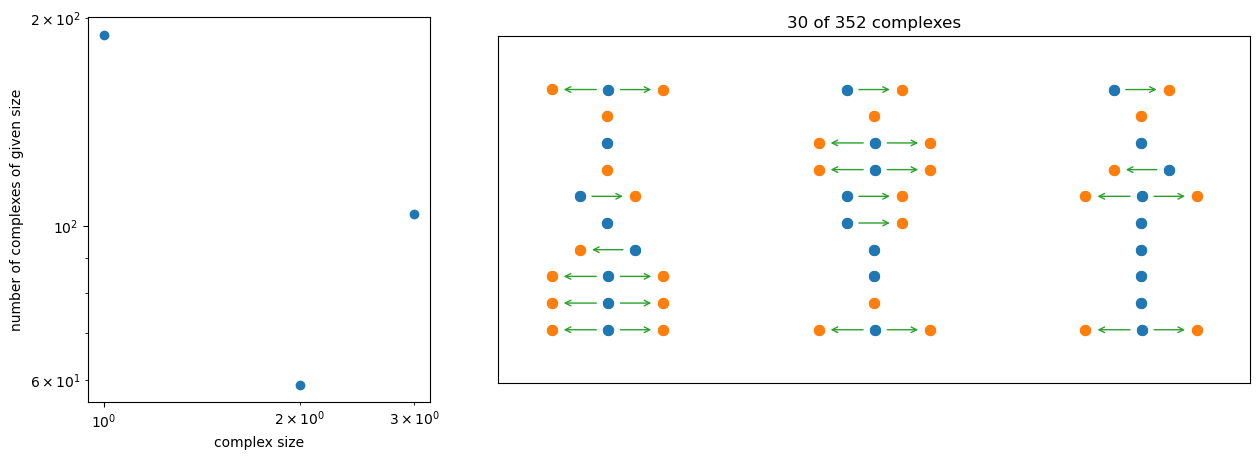

In [11]:
# Compute nodes and edges
nodes=[(f'A_{i[0]}',{'class':'A'}) for i in A.indices] + [(f'C_{i[0]}', {'class':'C'}) for i in C.indices]
edges=[(f'A_{i}', f'C_{j}', {'class':'J'}) for i,j in J.indices]

# Specify properties for visualize_complexes
node_properties={
    'A': {'node_color': 'C0', 'node_shape': 'o', 'node_size':50},
    'C': {'node_color': 'C1', 'node_shape': 'o', 'node_size':50},
}
edge_properties= {
    'J': {'edge_color': 'C2', 'width': 1, 'arrowstyle': '->', 'arrowsize': 10}
}

# Make figure
fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1, 3, figure=fig)

# Plot complex sizes
ax = fig.add_subplot(gs[0, 0])
fgv.show_complex_sizes(nodes, edges, ax=ax)

# Illustrate complexes
ax = fig.add_subplot(gs[0, 1:])
fgv.visualize_complexes(
    nodes=nodes,
    edges=edges,
    node_properties=node_properties,
    edge_properties=edge_properties,
    grid_shape=(10,3),
    x_spacing=5,
    y_spacing=0.5,
    ax=ax,
    iterations=1000,
    learning_rate=0.1)